# MARS Algorithm
The following code is running on an Anaconda environment with Python 3.8 using Numpy 1.21.5 and Scipy 1.10.1

These specifications are required to run the py-earth contribution to scikit-learn, the package that has an implementation of the MARS algorithm

In [2]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn

from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# try:
#     from google.colab import drive
#     IN_COLAB = True

# except ImportError:
#     IN_COLAB = False
# if IN_COLAB:
#   # Check if the directory exists (change '/content/drive' to your directory)
#   drive_dir = '/content/drive'
#   drive_mounted = os.path.isdir(drive_dir)

#   # Conditionally mount the drive
#   if not drive_mounted:
#       drive.mount('/content/drive')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# sys.path.insert(0, './underlay-backlog-estimation')
import utils.network as network_class
import utils.lstm_model as lstm_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer as data_processer_functions

In [4]:
# class Network:
#   def __init__(
#     self,
#     k_tunnels,
#     n_nodes,
#     m_edges,
#     underlay_service_rates,
#     external_arrival_rates,
#     tunnel_edge2node_adjacencies
#   ):
#     self.k_tunnels = k_tunnels
#     self.n_nodes = n_nodes
#     self.m_edges = m_edges
#     self.underlay_service_rates = underlay_service_rates
#     self.external_arrival_rates = external_arrival_rates
#     self.tunnel_edge2node_adjacencies = tunnel_edge2node_adjacencies
#     self.time = 0

#   def reset(self):
#     self.queue_backlogs = np.zeros([self.k_tunnels, self.n_nodes,])
#     self.time = 0
#     return self.queue_backlogs, self.time

#   def act(self):
#     return

#   def step(self, overlay_offered_rates):

#     # handle each tunnel as though it is a different network
#     for tt in range(self.k_tunnels):
#       # if(tt == 1):
#       #   print('t = ' + str(self.time))
#       #   print('Q(t) = ' + str(self.queue_backlogs[tt,:]))

#       # external arrivals
#       external_arrivals = np.random.poisson(self.external_arrival_rates[tt,:], self.n_nodes)
#       self.queue_backlogs[tt,:] += external_arrivals

#       # flows along edges
#       all_offered_rates = np.random.poisson(self.underlay_service_rates[tt,:], self.m_edges) + overlay_offered_rates[tt,:]

#       # make sure flows are not greater than current queue size
#       actual_rates = np.min(np.vstack(((self.tunnel_edge2node_adjacencies[tt,:,:].T < 0)@self.queue_backlogs[tt,:], all_offered_rates)), axis=0)

#       # apply flows
#       self.queue_backlogs[tt,:] += self.tunnel_edge2node_adjacencies[tt,:,:]@actual_rates
#       self.queue_backlogs[tt, self.queue_backlogs[tt,:] < 0] = 0
#       # if(tt == 1):
#       #   print('External arrivals = ' + str(external_arrivals))
#       #   print('Offered rates = ' + str(all_offered_rates))
#       #   print('Actual rates = ' + str(actual_rates))
#       #   print('Q(t+1) = ' + str(self.queue_backlogs[tt,:]))
#       #   print(' ')

#       # the destination queue is a sink
#       self.queue_backlogs[tt, -1] = 0

#     self.time += 1
#     return self.queue_backlogs, self.time

In [5]:
num_nodes = 5
num_edges = 5

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1,0,0,0,0], # -1 => node is edge's source
                                [1,-1,-1,0,0], # 1 => node is edge's destination
                                [0,1,0,-1,0],
                                [0,0,1,1,-1],
                                [0,0,0,0,1]])

In [6]:
# Tunnel level parameters
num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,0,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[0,:]  = np.array([1,0,0,0,0])
underlay_service_rates[0,:] = np.array([0,1,0,1,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,1,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[1,:]  = np.array([1,0,0,0,0])
underlay_service_rates[1,:] = np.array([0,0,1,0,1])

In [7]:
#get network class
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel,
    underlay_service_rates,
    external_arrival_rates)


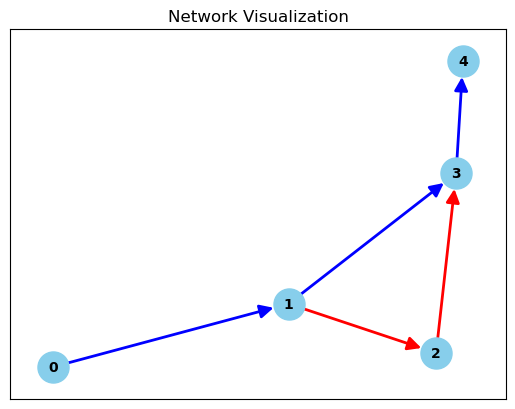

In [8]:
my_network.visualize(custom_seed = 1)


In [9]:
#simulate Network
packets_in_flight, tunnel_backlogs = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)
X,y=(packets_in_flight,tunnel_backlogs)

In [10]:
from pyearth import Earth
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
model = Earth()
model.fit(X_train, y_train)


Earth()

In [12]:
# Predict on the test set
y_pred = model.predict(X_test)


In [13]:
# Display model summary
print(model.summary())

Earth Model
------------------------------------------------------
Basis Function  Pruned  Coefficient 0  Coefficient 1  
------------------------------------------------------
(Intercept)     No      0.0344751      0.00764089     
x1              No      1.9997         1.78891        
h(x0-116)       No      1              11.2823        
h(116-x0)       No      -1             -0.799677      
h(x1-116)       No      -0.999703      1.6861         
h(116-x1)       No      0.999703       0.783532       
------------------------------------------------------
MSE: 32.7161, GCV: 32.7272, RSQ: 0.9521, GRSQ: 0.9521


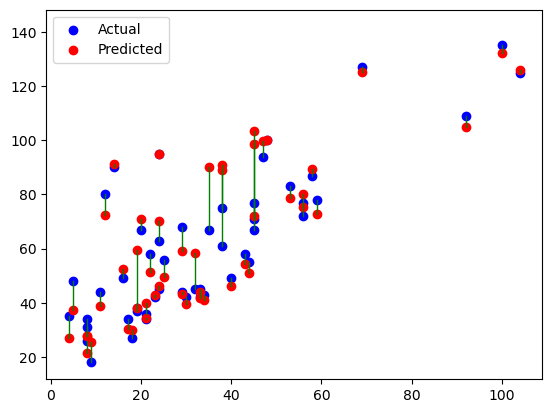

In [14]:
fig,ax=plt.subplots()
plt.scatter(X_test[:,1][1000:1050], y_test[:,1][1000:1050], color='blue', label='Actual')
plt.scatter(X_test[:,1][1000:1050], y_pred[:,1][1000:1050], color='red', label='Predicted')
plt.legend()

# Connecting points with the same x-values
for x, y1, y2 in zip(X_test[1000:1050], y_test[1000:1050], y_pred[1000:1050]):
    plt.plot([x, x], [y1, y2], color='green', linestyle='-', linewidth=1)


plt.show()